# Introduction

This notebook shows what Neural Network Training looks like under the hood.

Backpropagation is at the mathematical core of any modern Deep Neural Network Library let's say JAX or PyTorch.

Micrograd is an autograd engine.

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

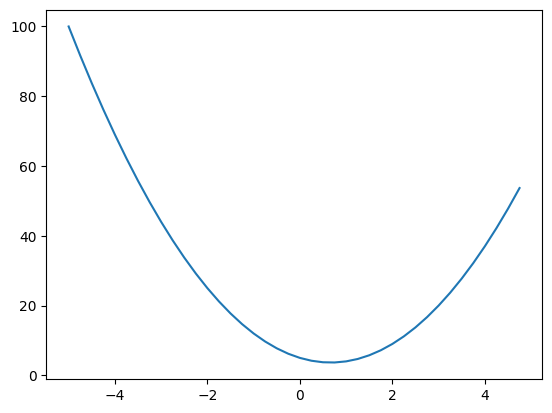

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
# Derivative of a simple function with one input

h = 0.000001
x = 3
print(f(x+h) - f(x))
(f(x+h) - f(x))/h

1.4000003002223593e-05


14.000003002223593

In [6]:
# Derivative of a simple function with multiple inputs

a = 2
b = -3
c = 10

d = a*b + c
print("d is: ", d)

h = 0.0001
c += h
d_inc = a*b + c

print("slope is: ", ((d_inc - d)/h))

d is:  4
slope is:  0.9999999999976694


# Value class of Micrograd

In [7]:
# Skeleton Code

class Value1:

  def __init__(self, data):
    self.data = data

  def __repr__(self):
    return f'Value(data={self.data})'

a = Value1(0.5)
a

Value(data=0.5)

In [8]:
# Now if we try and add two Value objects, that will result in an error as addition operation on Value objects is undefined.

b = Value1(0.3)

try:
  a + b
except Exception as emessage:
  print("Error is: ", emessage)


Error is:  unsupported operand type(s) for +: 'Value1' and 'Value1'


In [9]:
# Defining addition and multiplication operations on value object

class Value2:

  def __init__(self, data):
    self.data = data

  def __repr__(self): # prints a nicer looking expression
    return f'Value(data={self.data})'

  def __add__(self, other):
    out = Value2(self.data + other.data)
    return out

  def __mul__(self, other):
    out = Value2(self.data * other.data)
    return out

a = Value2(0.5)
b = Value2(0.3)

try:

  print("a + b = ", a + b) # function called is a.__add__(b)
  print("a * b =  ", a * b) # function called is a.__mul__(b)

except Exception as emessage:

  print("Error is: ", emessage)

c = Value2(0.2)

print("\na*b + c = ", a*b + c)  # function called is (a.__mul__(b)).__add__(c)

a + b =  Value(data=0.8)
a * b =   Value(data=0.15)

a*b + c =  Value(data=0.35)


In [10]:
# To be able to calculate the differential equation of the loss function,
# It is important to keep a track of the origin of each expression and the operation it is a result of
# To facilitate this, _children and _op arguments are introduced in the Value class

class Value3:

  def __init__(self, data, _children=(), _op=''):
    self.data = data
    self._prev = set(_children)
    self._op = _op

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    out = Value3(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value3(self.data * other.data, (self, other), '*')
    return out

a = Value3(5)
b = Value3(3)
c = Value3(1)
d = a*b
e = d + c

print("Children at node d are: ", d._prev)
print("Operation at node d is: ", d._op)

print("\nChildren at node e are: ", e._prev)
print("Operation at node e is: ", e._op)

Children at node d are:  {Value(data=3), Value(data=5)}
Operation at node d is:  *

Children at node e are:  {Value(data=15), Value(data=1)}
Operation at node e is:  +


In [11]:
# Defined the label and grad attributes in Value class.
# Grad represents the derivative of the output wrt to the Value store in th eclass object.
# Grad variable is defined and initialized to zero in the Value class.

class Value4:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    out = Value4(self.data + other.data, (self, other), '+')
    return out

  def __mul__(self, other):
    out = Value4(self.data * other.data, (self, other), '*')
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value4(t, (self, ), 'tanh()')
    return out

a = Value4(5, label='a')
b = Value4(3, label = 'b')
c = Value4(1, label = 'c')
d = a*b
d.label = 'd'
e = d + c
e.label = 'e'
f = Value4(-2, label='f')
L = e * f; L.label = 'L'

print("Children at node d are: ", d._prev)
print("Operation at node d is: ", d._op)

print("\nChildren at node e are: ", e._prev)
print("Operation at node e is: ", e._op)

print("\nChildren at node e are: ", L._prev)
print("Operation at node e is: ", L._op)

Children at node d are:  {Value(data=5), Value(data=3)}
Operation at node d is:  *

Children at node e are:  {Value(data=1), Value(data=15)}
Operation at node e is:  +

Children at node e are:  {Value(data=16), Value(data=-2)}
Operation at node e is:  *


In [12]:
# Visual Graph for Expressions

from graphviz import Digraph

def trace(root):

  # builds the nodes and edges in the graph

  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)

  return nodes, edges

def draw_dot(root):

  dot = Digraph(format='svg', graph_attr= {'rankdir': 'LR'}) # LR = Left to Right
  nodes, edges = trace(root)

  for n in nodes:
    uid = str(id(n))
    # build rectangular node for a value in graph
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data,  n.grad), shape = 'record')

    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
      dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


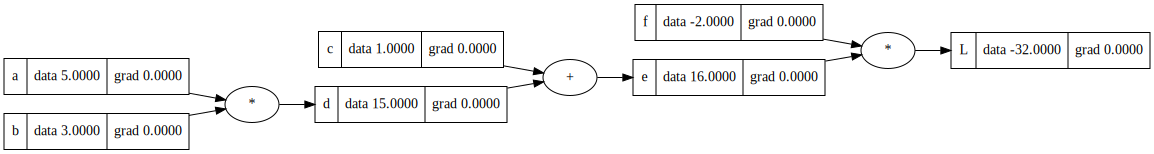

In [13]:
draw_dot(L)

In [14]:
# Placeholder function to calculate derivative of the mathematical expressions

def exprDerivative():

  a = 5
  b = 3
  c = 1
  d = a*b
  e = d + c
  f = -2
  L1 = e * f

  h = 0.0001


  a = 5
  b = 3
  b += h
  c = 1
  d = a*b
  e = d + c
  f = -2
  L2 = e * f

  print((L2 - L1)/h)

exprDerivative()


-10.000000000047748


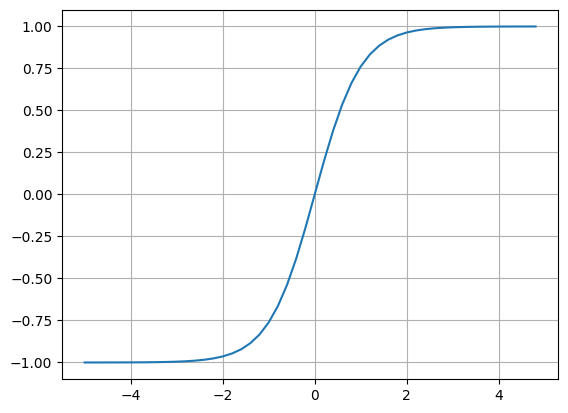

In [15]:
plt.plot(np.arange(-5,5,0.2), np. tanh(np.arange(-5,5,0.2))); plt.grid();

In [16]:
# Performing backprop at each step manually is crazy, modify the Value class to accommodate this operation
# A variable, _backward is defined to hold an empty function
# This variable will be used to trigger back propagation in the chain of nodes and to propagate the derivative of the node to it's children

In [17]:
class Value5:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    out = Value5(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1 * out.grad
      other.grad = 1 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value5(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value5(t, (self, ), 'tanh()')

    def _backward():
      self.grad = (1 - t**2) * out.grad # derivative of tanh multiplied by out.grad because it's a part of the chain of nodes
                                        #(follows chain rule for derivation operation)
    out._backward = _backward

    return out

  def backward(self):
    # build topological graph
    topo = []
    visited = set()

    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)

    build_topo(self)
    # set grad for the node to 1
    self.grad = 1
    # call _backward in reverse order of nodes
    for node in reversed(topo):
      node._backward()

In [18]:
# build a neuron and update Value class to facilitate tanh() activation function

# inputs
x1 = Value5(2.0, label='x1')
x2 = Value5(0.0, label='x2')

# weights
w1 = Value5(-3.0, label='w1')
w2 = Value5(1.0, label='w2')

# bias
b = Value5(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

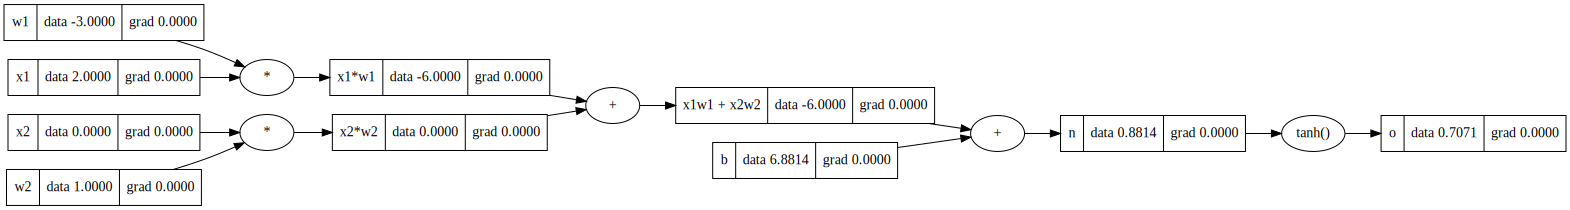

In [19]:
draw_dot(o)

In [20]:
o.grad = 1
o._backward()

n._backward()

x1w1x2w2._backward()

x1w1._backward()
x2w2._backward()

In [21]:
# instead of manually calling _backward() at each node, modify code for them to be called automatically upon initiation
# To achieve this, first a topological graph is built.
# In a topological graph, the parent nodes are processed and added to the list only after all the child nodes are processed.

In [22]:
# Build topological graph

topo = []
visited = set()

def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

In [23]:
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [24]:
# modify the Value class to facilitate auto backward propagation operation
o.backward()

In [25]:
# This results in a bug in the code that is deminstrated below

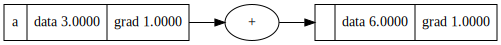

In [26]:
a = Value5(3.0, label='a')
b = a + a; b. Label = 'b'
b.backward()
draw_dot(b)

# The gradient of a is supposed to be 2, but is given as 1 because of the way we defined mathematical operations in the Value class

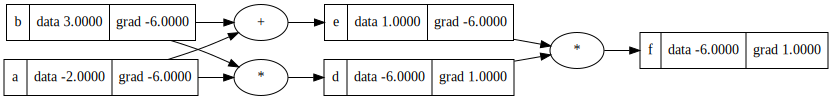

In [27]:
a = Value5(-2.0, label='a')
b = Value5(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f. label = 'f'

f.backward ()

draw_dot(f)

In [28]:
# These errors occur everytime a variable occurs more than once in the mathematical expressions
# The cause is that everytime the backward propagation is initiated, grad value is being overwritten,
# this has to be changed such that the grad values accumulate and don't get lost

In [29]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1 * out.grad
      other.grad += 1 * out.grad
    out._backward = _backward
    return out

  def __neg__(self):
    return Value(self.data * -1)

  def __sub__(self, other):
    return self + (-other)

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): #self/other
    return self * (other**-1)

  def __pow__(self, other):
    assert isinstance(other,(int, float)), "only supports int/float powers"
    out = Value(self.data**other, (self, ), f'**{other}')
    def _backward():
      self.grad += other * (self.data**(other-1)) * out.grad
    out._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh()')
    def _backward():
      self.grad += (1 - t**2) * out.grad # derivative of tanh multiplied by out.grad because it's a part of the chain of nodes
                                        #(follows chain rule for derivation operation)
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self):
    topo = [] # build topological graph
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    self.grad = 1 # set grad for the node to 1
    for node in reversed(topo): # call _backward in reverse order of nodes
      node._backward()

In [30]:
# build a neuron and update Value class to facilitate tanh() activation function

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

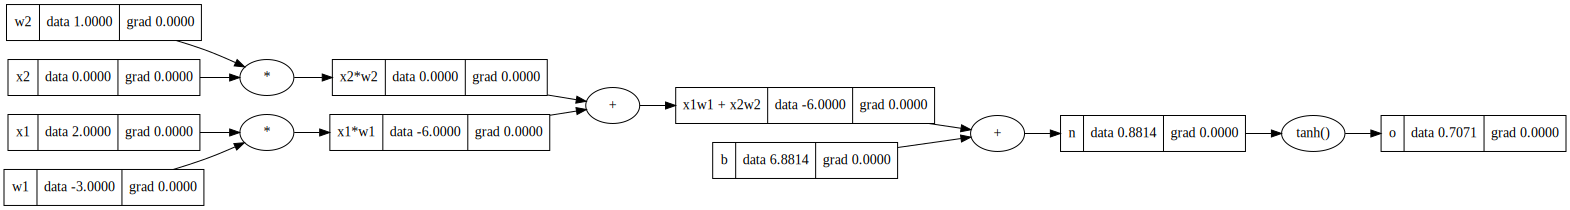

In [31]:
draw_dot(o)

In [32]:
o.backward()

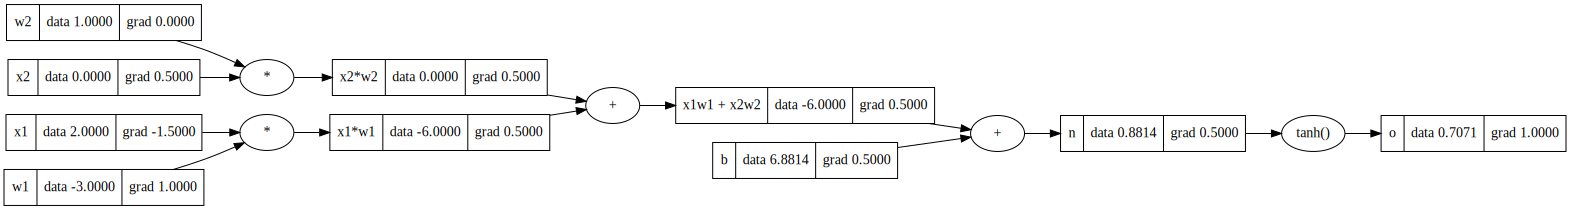

In [33]:
draw_dot(o)

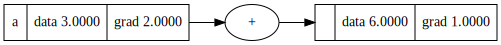

In [34]:
# verify the grad values

a = Value(3.0, label='a')
b = a + a; b. Label = 'b'
b.backward()
draw_dot(b)

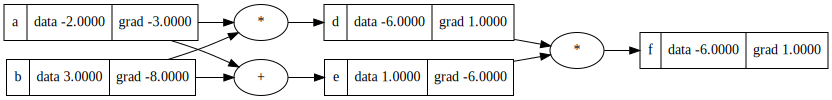

In [35]:
# verify the grad values

a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f. label = 'f'

f.backward ()

draw_dot(f)

In [36]:
# Add the following operations to the Value class

# Add Value object with a scalar
# Support scalar * Value object as well
# Support division operation
# Break tanh operation into exponential operations
# Support power operation
# Support subtraction

In [37]:
#verify the addition of above operations

t = a + 5
t

Value(data=3.0)

In [38]:
2 * a

Value(data=-4.0)

In [39]:
a / b

Value(data=-0.6666666666666666)

In [40]:
a/2

Value(data=-1.0)

In [41]:
a**5

Value(data=-32.0)

In [42]:
a - b

Value(data=-5.0)

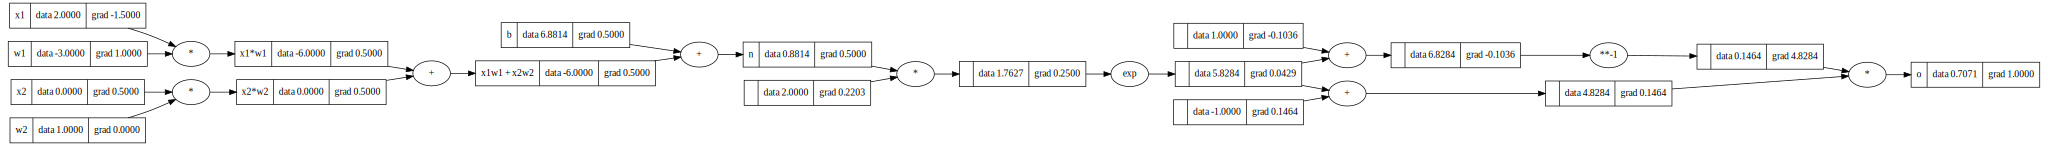

In [43]:
# replace tanh with it's exponential form

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'

n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp() # e ^ 2n
o = (e-1)/(e+1); o.label = 'o'
o.backward()
draw_dot(o)

In [44]:
# define Neuron class

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

class Layer:

  def __init__(self, nin, nout): # nin is no. of input neurons, nout is no. of neurons in the layer
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x


x = [5.0, 9.0, 11.0]
n = Neuron(3)
n(x)

Value(data=0.9965371487039681)

In [45]:
# in a neural network layer, the neurons are independent to each other but ar efully connected with the input nodes

x = [5.0, 9.0, 11.0]
n = Layer(3, 5)
n(x)

[Value(data=0.38264281484716683),
 Value(data=-0.9999966521059703),
 Value(data=-0.9942743218132342),
 Value(data=0.9999999999999998),
 Value(data=-0.999999801585286)]

In [46]:
x = [5.0, 9.0, 11.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7054957590346058)

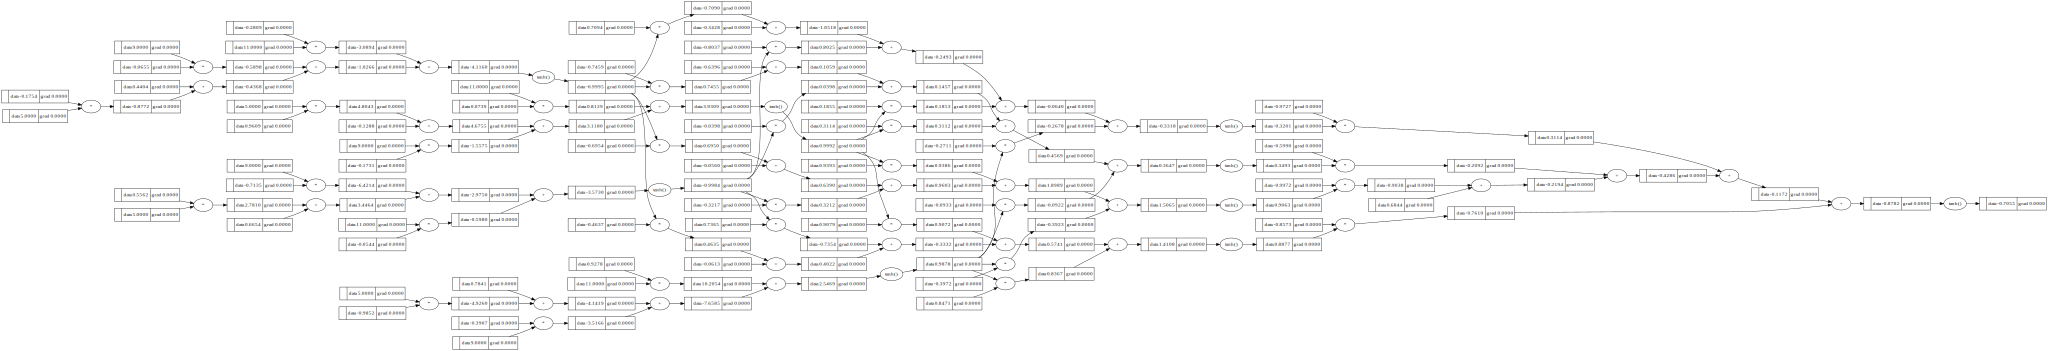

In [47]:
draw_dot(n(x))